## Imports

In [1]:
from keras.regularizers import l1_l2
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
from sklearn.utils import shuffle
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.constraints import max_norm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import tensorflow as tf
from joblib import dump, load
from tensorflow.keras import losses
from astropy.coordinates import SkyCoord
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import os
import datetime

## Input Data

In [ ]:
# Load the data
lightCurve = pd.read_csv("/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/Forecast KN LC/Data/lightcurveDataCom7988.csv")
features = pd.read_csv("/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/Forecast KN LC/Data/featureDataCom7988_pAstro.csv")

# Drop rows from lightCurve where 'simulation_id' is in [1624, 43162, 97688]
ids_to_drop = [1624, 43162, 97688]
lightCurve = lightCurve[~lightCurve['simulation_id'].isin(ids_to_drop)]

# Drop unnecessary columns from the features dataframe
features = features.drop(["simulation_id", 'far', 'snr', 'longitude','latitude'], axis=1)

# Filter the light curve data
filtered_df = lightCurve[lightCurve['filter'].isin(['ztfg', 'ztfr', 'ztfi'])].copy()
filtered_df = filtered_df[['filter', 'mag']]

num_light_curves = features.shape[0]

# Ensure the data is in the correct order
filter_order = ['ztfg', 'ztfr', 'ztfi']
filtered_df['filter'] = pd.Categorical(filtered_df['filter'], categories=filter_order, ordered=True)
filtered_df = filtered_df.sort_index()

# Consistency check
total_points = len(filtered_df)
num_time_points = total_points // (num_light_curves * len(filter_order))

# Reshape the data
y = np.empty((num_light_curves, num_time_points * len(filter_order)), dtype=filtered_df['mag'].dtype)
ztfg_mags = filtered_df[filtered_df['filter'] == 'ztfg']['mag'].values.reshape(num_light_curves, num_time_points)
ztfr_mags = filtered_df[filtered_df['filter'] == 'ztfr']['mag'].values.reshape(num_light_curves, num_time_points)
ztfi_mags = filtered_df[filtered_df['filter'] == 'ztfi']['mag'].values.reshape(num_light_curves, num_time_points)

# Populate reshaped array
for i in range(num_time_points):
    y[:, i * 3 + 0] = ztfg_mags[:, i]
    y[:, i * 3 + 1] = ztfr_mags[:, i]
    y[:, i * 3 + 2] = ztfi_mags[:, i]

# Adjust num_time_points to 30 by removing the last 41 points
num_time_points = 30
y = y[:, :num_time_points * len(filter_order)]

# Time array (adjusted to 30 points)
t_min = 0.1
t_max = 6.0
dt = 0.2
time_single = np.linspace(t_min, t_max, num_time_points)

# Standardize the feature data
feature_scaler = RobustScaler()
X = feature_scaler.fit_transform(features)
dump(feature_scaler, 'feature_scaler.joblib')
# Standardize the target data
target_scaler = RobustScaler()
y = target_scaler.fit_transform(y)
dump(target_scaler, 'target_scaler.joblib')
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reshape y data for LSTM input
y_train_reshaped = y_train.reshape((y_train.shape[0], num_time_points, len(filter_order)))
y_test_reshaped = y_test.reshape((y_test.shape[0], num_time_points, len(filter_order)))

# Reshape X data for LSTM input
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

## Model

In [4]:
# Define the LSTM model
model = Sequential(name="LSTM_Model")

# First Bidirectional LSTM Layer with Batch Normalization and Dropout
model.add(Bidirectional(LSTM(400, activation='relu', return_sequences=True,
                             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                             kernel_constraint=max_norm(3.0),
                             input_shape=(1, X_train.shape[1])),
                        name="Bidirectional_LSTM_1"))
#model.add(BatchNormalization(name="BatchNormalization_1"))
model.add(Dropout(0.1, name="Dropout"))  # Increased dropout rate

# Second Bidirectional LSTM Layer with Batch Normalization
model.add(Bidirectional(LSTM(300, activation='relu', return_sequences=True,
                             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                             kernel_constraint=max_norm(3.0)),
                        name="Bidirectional_LSTM_2")) 

model.add(Dropout(0.1)) 

# Second Bidirectional LSTM Layer with Batch Normalization
model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True,
                             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                             kernel_constraint=max_norm(3.0)),
                        name="Bidirectional_LSTM_3")) 

model.add(Dropout(0.1)) 
# Second Bidirectional LSTM Layer with Batch Normalization
model.add(Bidirectional(LSTM(150, activation='relu', return_sequences=False,
                             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                             kernel_constraint=max_norm(3.0)),
                        name="Bidirectional_LSTM_4"))
#model.add(BatchNormalization(name="BatchNormalization_2"))
model.add(Dropout(0.1))  # Increased dropout rate

# Intermediate dense layer
model.add(Dense(200, activation='relu', name="Dense_Intermediate"))
model.add(Dropout(0.05))
# Intermediate dense layer
model.add(Dense(100, activation='relu', name="Dense_Intermediate1"))
model.add(Dropout(0.05))
# Dense output layer
model.add(Dense(90, name="Dense_Output"))

## Model

In [5]:
# Compile the model with a lower learning rate and gradient clipping
optimizer = Adam(learning_rate=0.0003, clipnorm=1.0)  # Only clipnorm is used
model.compile(optimizer=optimizer, loss='mse')

# Implement early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Create a TensorBoard callback
logdir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)

# Train the model
history = model.fit(X_train_reshaped, y_train, 
                    epochs=300, batch_size=32, validation_split=0.3, 
                    verbose=1, callbacks=[early_stopping, lr_reduction])

# Save the trained model
dump(model, 'LSTM_model.joblib')
model.summary()

Epoch 1/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 1.7634 - val_loss: 0.9230 - learning_rate: 3.0000e-04
Epoch 2/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.7590 - val_loss: 0.3285 - learning_rate: 3.0000e-04
Epoch 3/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.2861 - val_loss: 0.2306 - learning_rate: 3.0000e-04
Epoch 4/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.2463 - val_loss: 0.2224 - learning_rate: 3.0000e-04
Epoch 5/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.2253 - val_loss: 0.2252 - learning_rate: 3.0000e-04
Epoch 6/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.2378 - val_loss: 0.2151 - learning_rate: 3.0000e-04
Epoch 7/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.2383 - val_loss: 0.2164 - learning_rate: 3.0000e-04
Epoch 8/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.2174 - val_loss: 0.2222 - learning_rate: 3.0000e-04
Epoch 9/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.2223 - v

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Bidirectional_LSTM_1            │ (None, 1, 800)         │     1,302,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 1, 800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bidirectional_LSTM_2            │ (None, 1, 600)         │     2,642,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bidirectional_LSTM_3            │ (None, 1, 400)         │     1,281,600 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bidirectional_LSTM_4            │ (None, 300)            │       661,200 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Intermediate (Dense)      │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Intermediate1 (Dense)     │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Output (Dense)            │ (None, 90)             │         9,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,930,972 (68.40 MB)

 Trainable params: 5,976,990 (22.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,953,982 (45.60 MB)

## Predictions

Test MSE with MC Dropout: 0.1897, Test R² with MC Dropout: 0.7192
Test MSE with MC Dropout (inverted): 1.2044
Test R² with MC Dropout (inverted): 0.8216


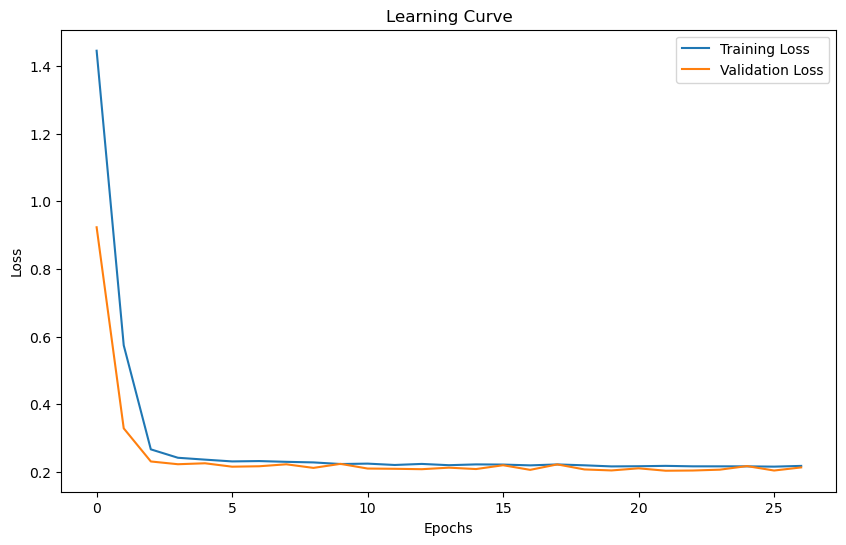

In [7]:
def predict_with_uncertainty(model, X, n_iter=1000):

    # Perform n_iter forward passes and collect the predictions
    preds = [model(X, training=True) for _ in range(n_iter)]  # Dropout active during inference
    preds = np.array(preds)
    
    # Calculate mean and standard deviation of the predictions
    mean_preds = preds.mean(axis=0)
    uncertainty = preds.std(axis=0)
    
    return mean_preds, uncertainty

# Perform MC Dropout to predict with uncertainty
n_mc_samples = 1000 # Number of forward passes
mean_preds, uncertainty = predict_with_uncertainty(model, X_test_reshaped, n_iter=n_mc_samples)

# Reshape the mean predictions to match the shape used during scaling (num_samples, num_time_points * num_filters)
mean_preds_flat = mean_preds.reshape(mean_preds.shape[0], num_time_points * 3)  
# Invert the standardization for the mean predictions
mean_preds_inverted = target_scaler.inverse_transform(mean_preds_flat).reshape(mean_preds.shape[0], num_time_points, 3)

# Reshape uncertainty to match mean_preds_inverted shape
uncertainty_reshaped = uncertainty.reshape(uncertainty.shape[0], num_time_points, 3)
# Evaluate the model using the mean predictions

test_mse_mc = mean_squared_error(y_test.flatten(), mean_preds_flat.flatten())
test_r2_mc = r2_score(y_test.flatten(), mean_preds_flat.flatten())

print(f'Test MSE with MC Dropout: {test_mse_mc:.4f}, Test R² with MC Dropout: {test_r2_mc:.4f}')

# Reshape y_test to match the scaler's expected input (num_samples, num_time_points * 3)
y_test_flat = y_test.reshape(y_test.shape[0], num_time_points * 3)

# Inverse-transform y_test using the same scaler
y_test_inverted = target_scaler.inverse_transform(y_test_flat).reshape(y_test.shape[0], num_time_points, 3)

# Flatten both for metric computation
y_test_inverted_flat = y_test_inverted.flatten()
mean_preds_inverted_flat = mean_preds_inverted.flatten()

# Compute metrics on the inverse-transformed data
test_mse_mc = mean_squared_error(y_test_inverted_flat, mean_preds_inverted_flat)
test_r2_mc = r2_score(y_test_inverted_flat, mean_preds_inverted_flat)


# Print results
print(f"Test MSE with MC Dropout (inverted): {test_mse_mc:.4f}")
print(f"Test R² with MC Dropout (inverted): {test_r2_mc:.4f}")


# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

Plotting all light curves with MSE around 0.18 ± 0.01:


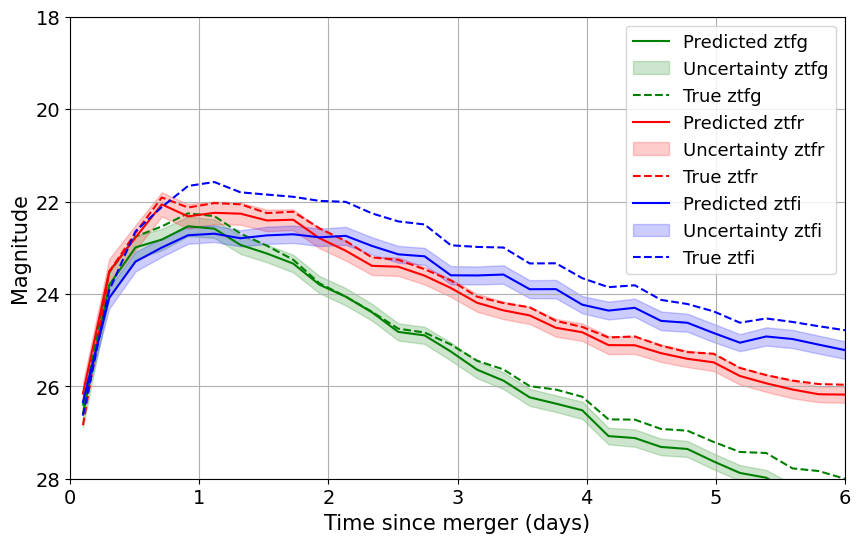

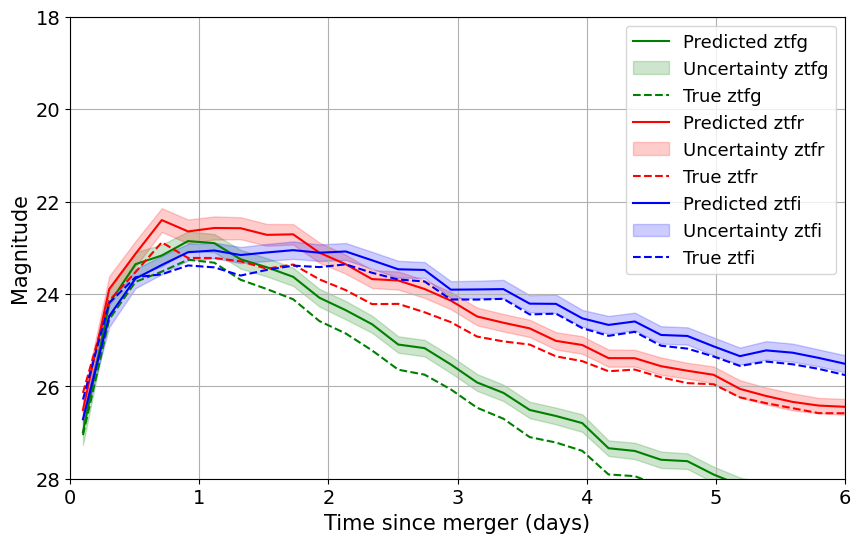

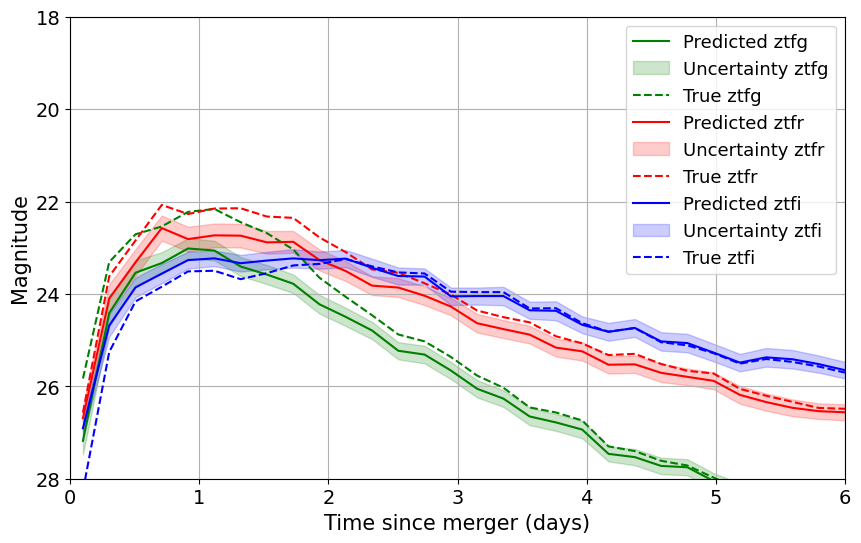

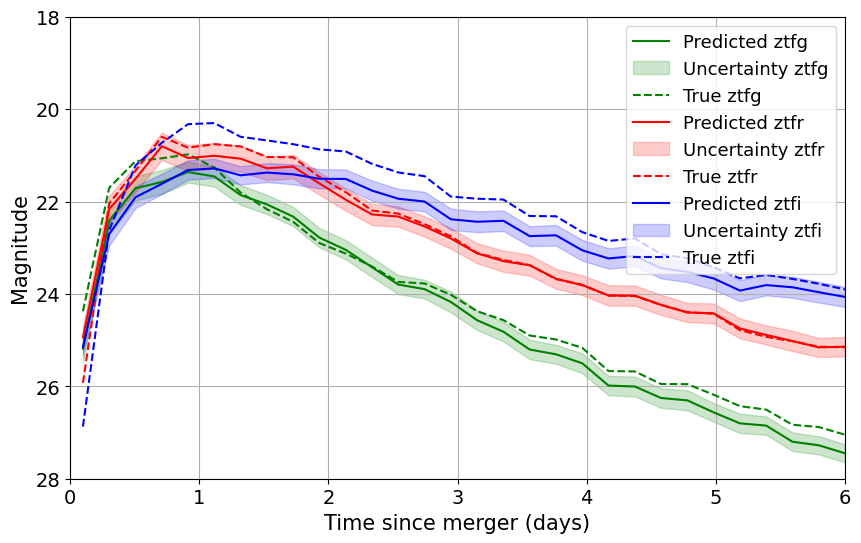

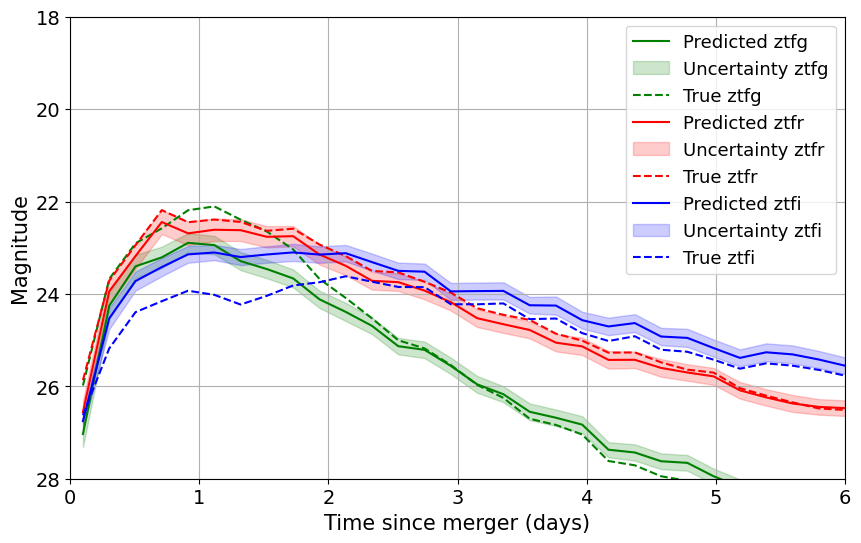

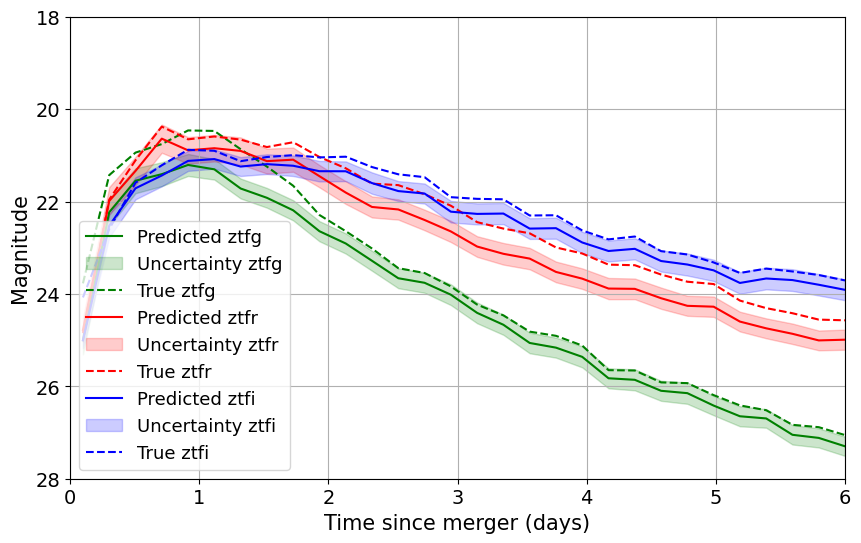

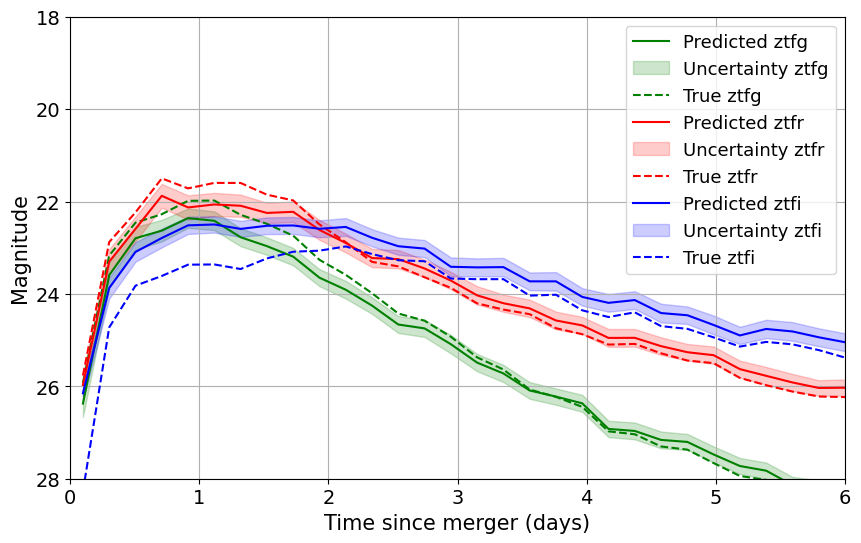

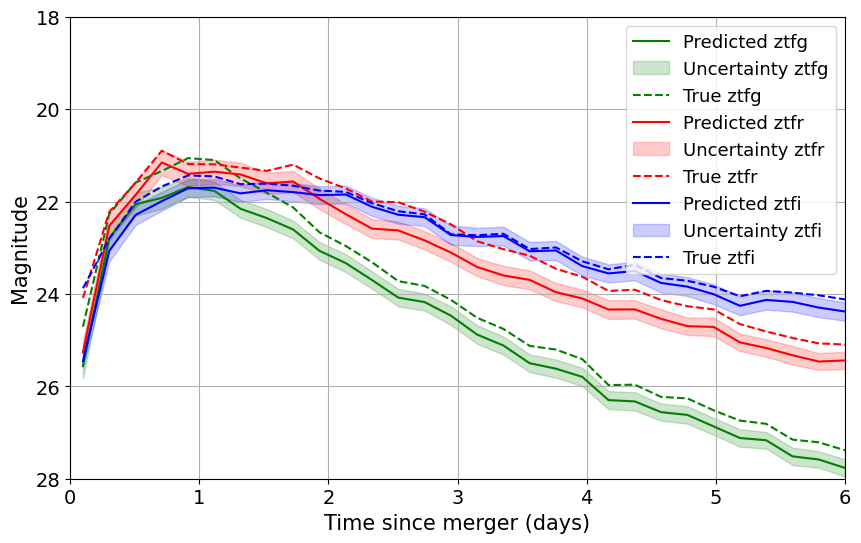

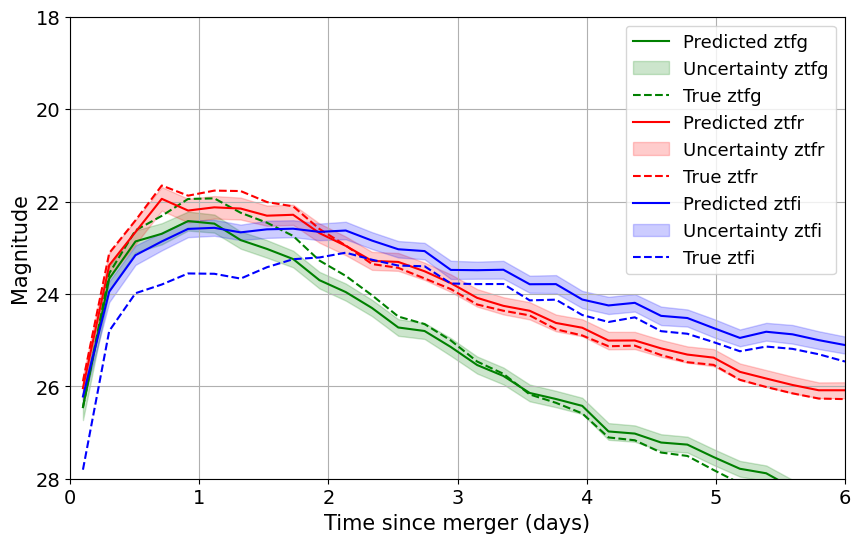

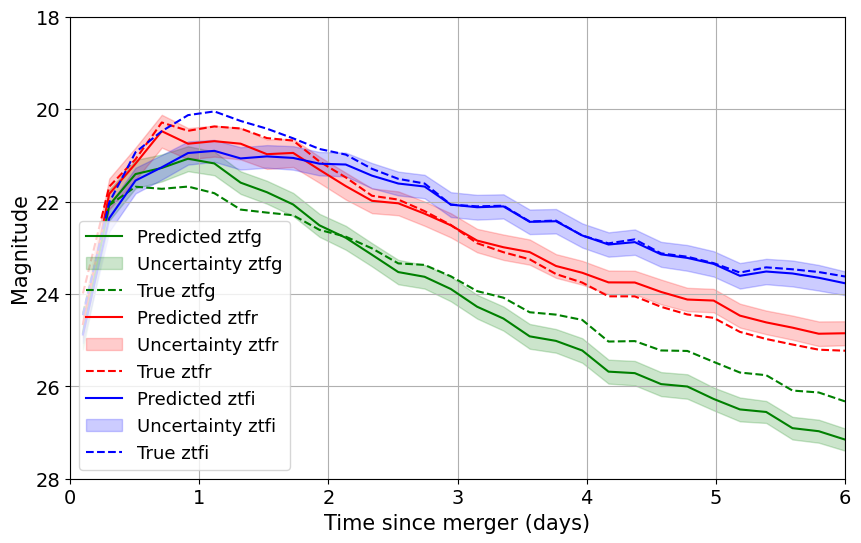

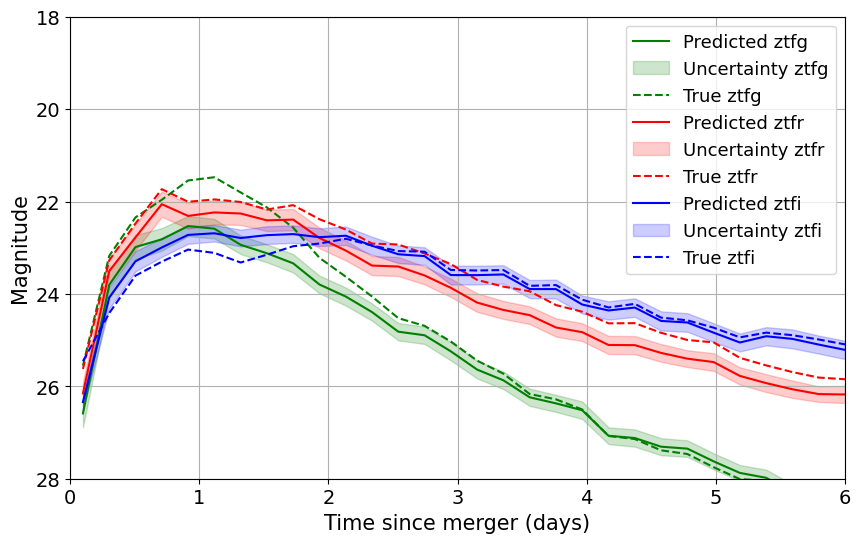

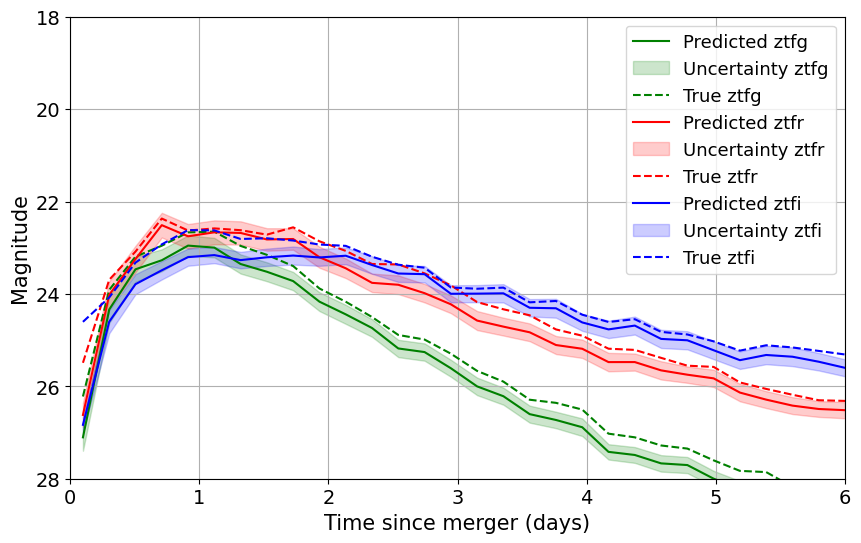

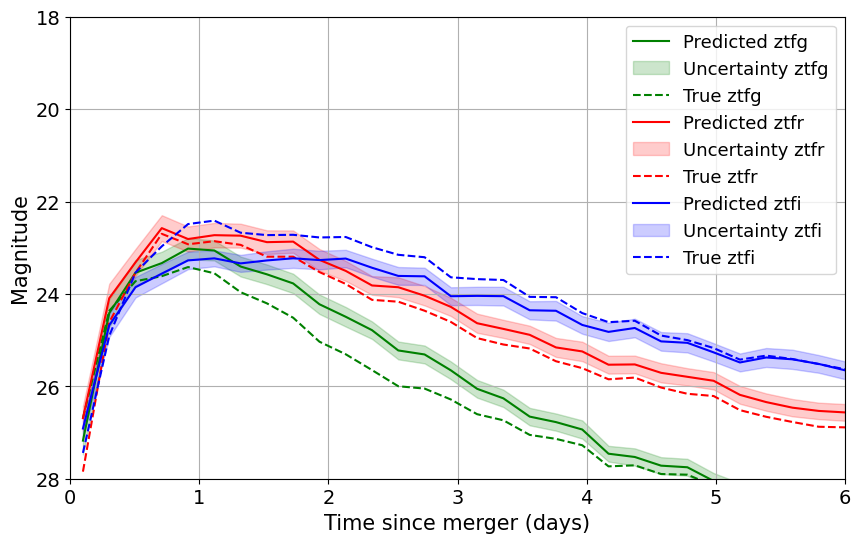

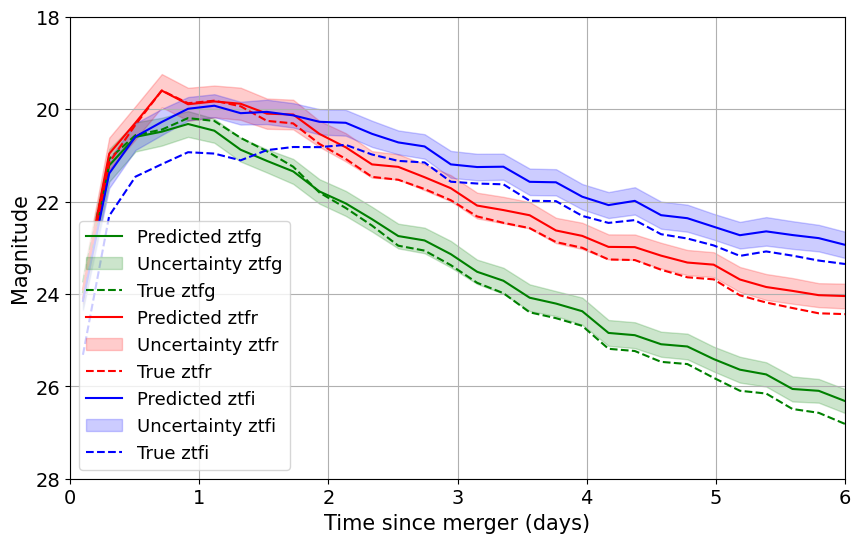

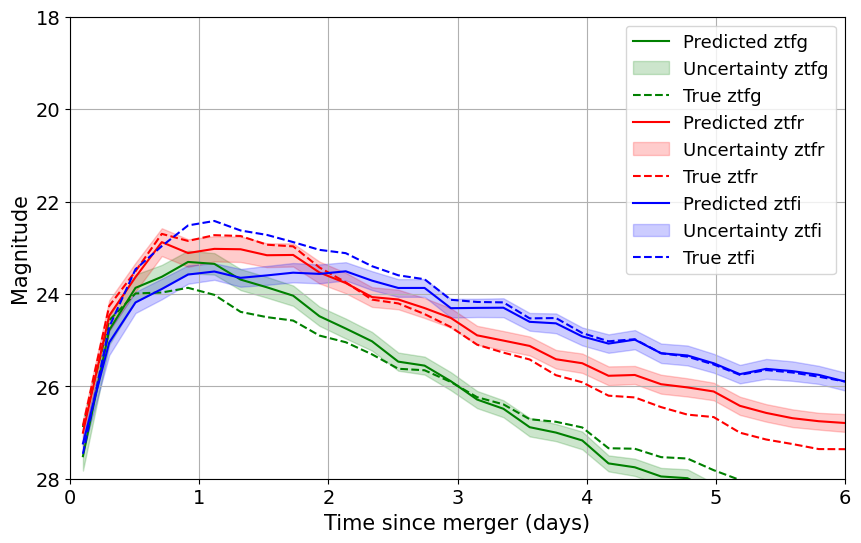

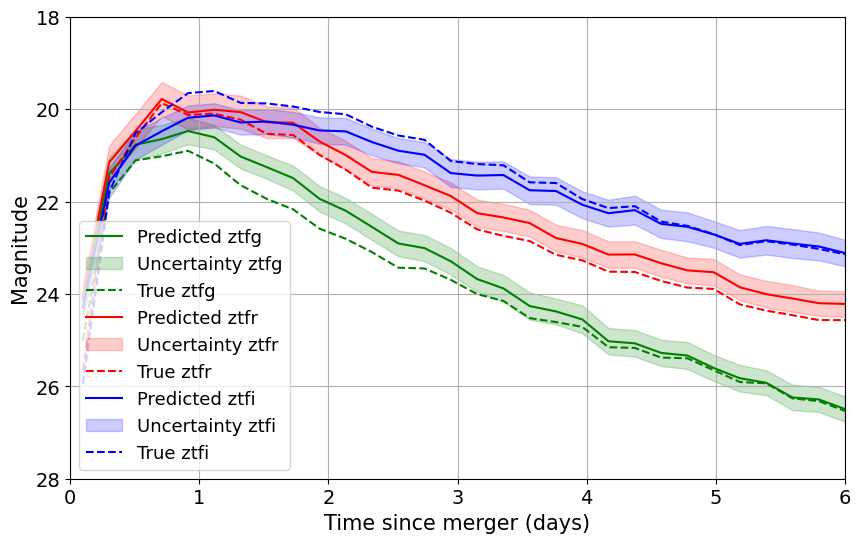

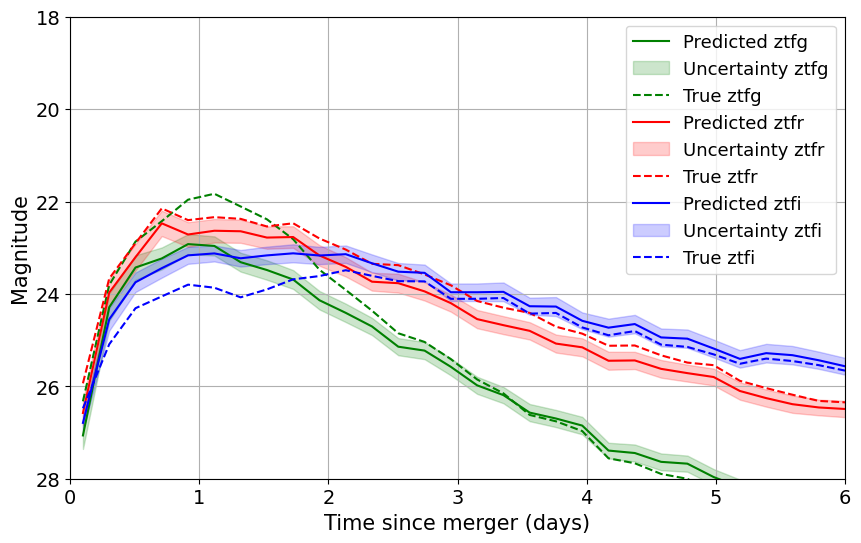

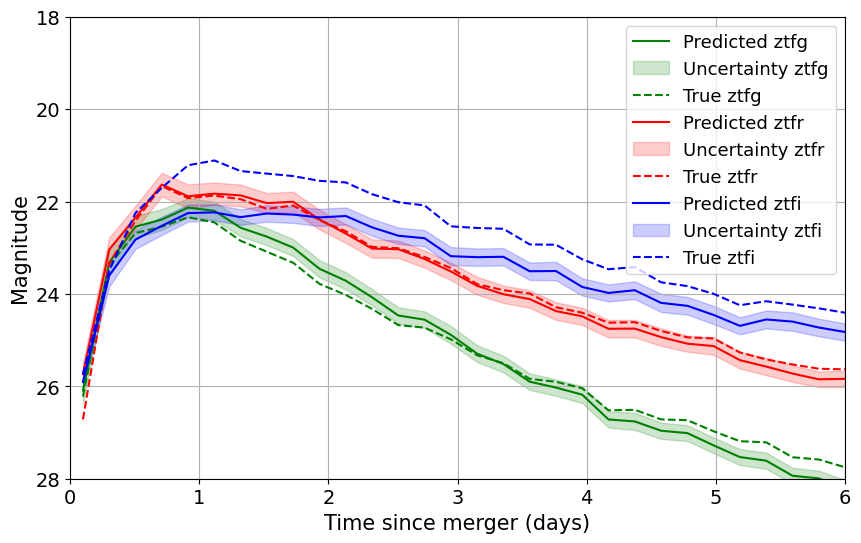

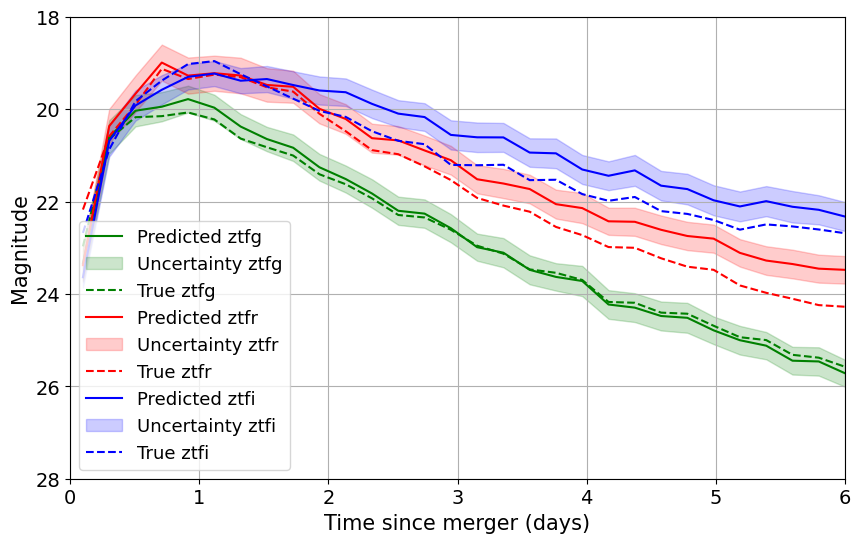

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# Time points for plotting
time_points = np.tile(time_single, (X_test_reshaped.shape[0], 1))

# Invert the scaling for y_test to compare with predictions

y_test_inverted = target_scaler.inverse_transform(y_test.reshape(y_test.shape[0], -1)).reshape((y_test.shape[0], num_time_points, 3))
mse_per_curve = np.mean((y_test_inverted - mean_preds_inverted) ** 2, axis=(1, 2))  # MSE for each light curve across all time points and filters

mse_target = 0.18
tolerance = 0.01  # Define a tolerance level to find light curves with MSE close to 3.6
selected_index = np.where(np.abs(mse_per_curve - mse_target) < tolerance)[0]  # Get the indices of the light curves that meet the condition
# Find all indices where MSE is within the specified tolerance
selected_indices = np.where(np.abs(mse_per_curve - mse_target) < tolerance)[0]

# Plot all light curves that meet the MSE criteria
if len(selected_indices) > 0:
    print(f"Plotting all light curves with MSE around {mse_target} ± {tolerance}:")

    filter_names = ['ztfg', 'ztfr', 'ztfi']
    colors = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'blue'}

    for example_idx in selected_indices:
        plt.figure(figsize=(10, 6))

        # Plot the ZTFg, ZTFr, and ZTFi filters separately for the selected light curve
        mean_curve = mean_preds_inverted[example_idx]
        true_curve = y_test_inverted[example_idx]

        # Loop over each filter
        for i, filter_name in enumerate(filter_names):
            plt.plot(time_single, mean_curve[:, i], label=f'Predicted {filter_name}', color=colors[filter_name])
            plt.fill_between(time_single, 
                             mean_curve[:, i] - 3 * uncertainty_reshaped[example_idx, :, i], 
                             mean_curve[:, i] + 3 * uncertainty_reshaped[example_idx, :, i], 
                             color=colors[filter_name], alpha=0.2, label=f'Uncertainty {filter_name}')
            # Plot the true values for comparison
            plt.plot(time_single, true_curve[:, i], '--', color=colors[filter_name], label=f'True {filter_name}')

        # Add labels and title
        plt.xlabel('Time since merger (days)', fontsize=15)
        plt.ylabel('Magnitude', fontsize=15)
        plt.ylim(28, 18)  
        plt.xlim(0, 6) 
        #plt.title(f'Light Curve with MSE ~ {mse_target} (Light Curve Index: {example_idx})')
        plt.tick_params(axis='both', labelsize=14)
        plt.legend(fontsize=13)
        plt.grid(True)
        plt.show()
else:
    print(f"No light curves found with MSE close to {mse_target}.")

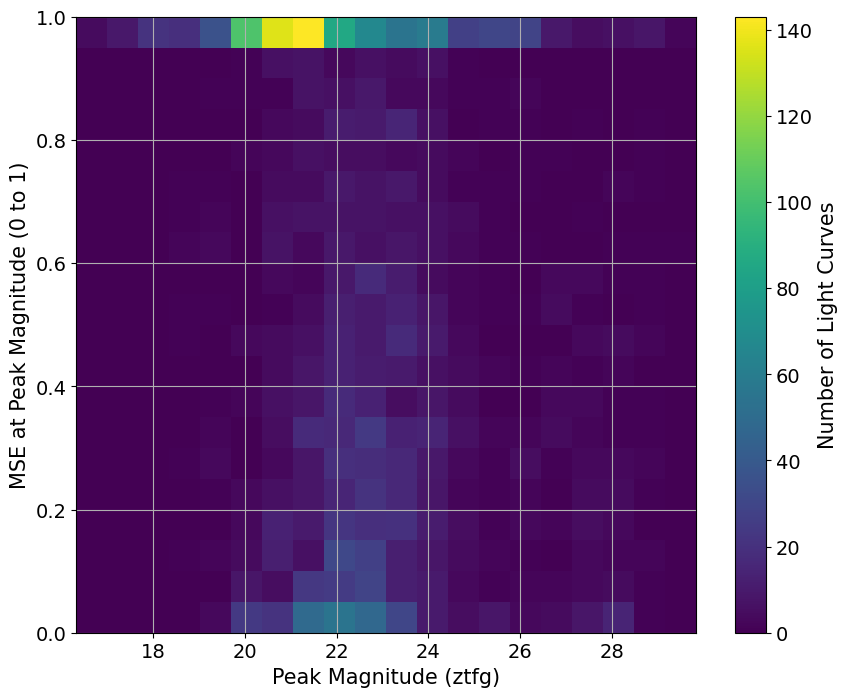

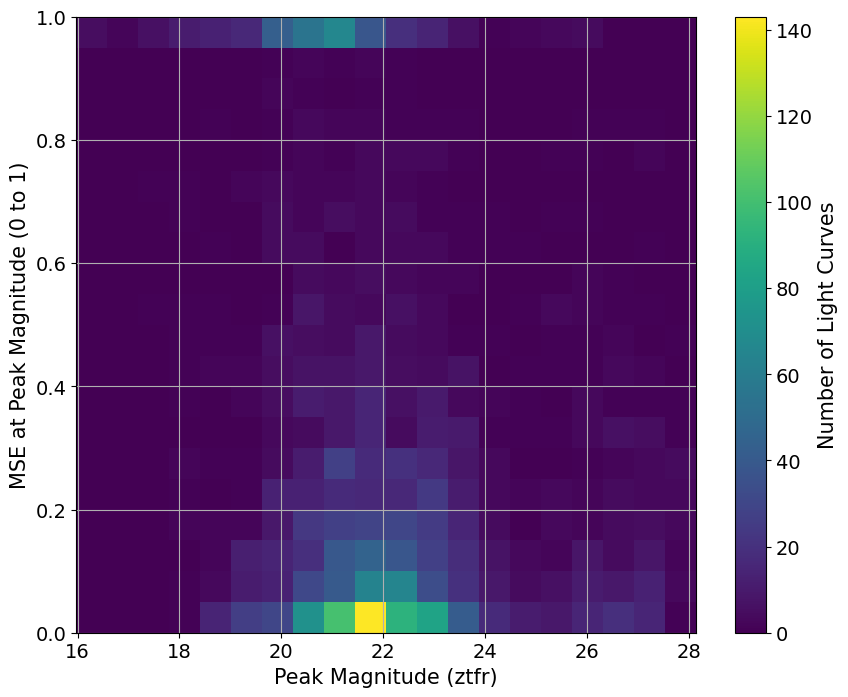

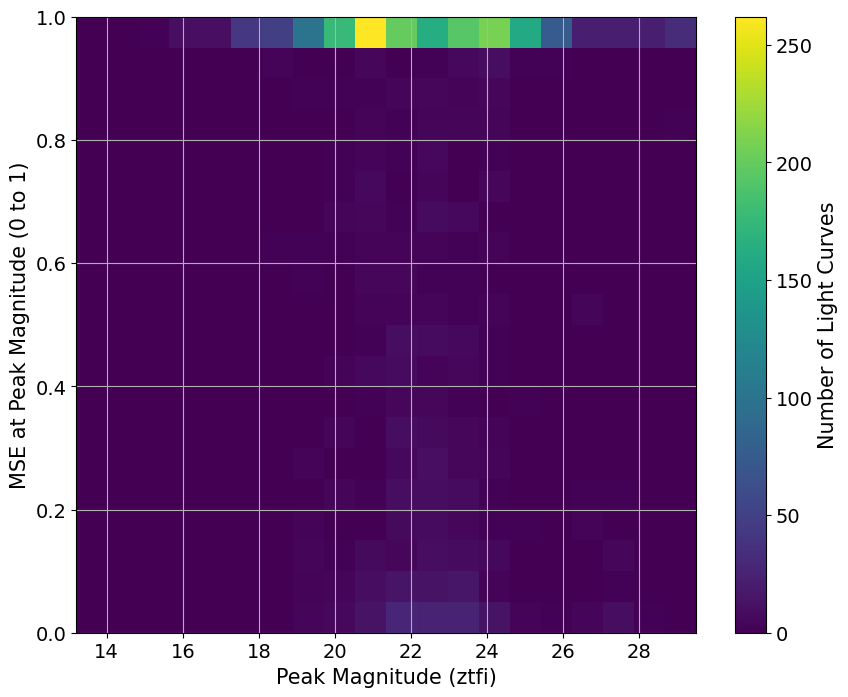

In [10]:
import matplotlib.pyplot as plt
import numpy as np
filter_names = ['ztfg', 'ztfr', 'ztfi']
for i, filter_name in enumerate(filter_names):
    # Step 1: Calculate the index of the minimum value (peak magnitude) for the current filter
    peak_indices = np.argmin(y_test_inverted[:, :, i], axis=1)  # Shape (num_samples,)

    # Step 2: Extract the corresponding predicted values at the peak magnitude indices
    peak_preds_filter = mean_preds_inverted[np.arange(mean_preds_inverted.shape[0]), peak_indices, i]

    # Step 3: Extract the corresponding true values at the peak magnitude indices
    peak_true_filter = y_test_inverted[np.arange(y_test_inverted.shape[0]), peak_indices, i]

    # Step 4: Calculate the MSE at the peak magnitude for each light curve
    mse_at_peak_filter = (peak_true_filter - peak_preds_filter) ** 2  # Shape (num_samples,)

    # Clip MSE values between 0 and 1 for the y-axis range
    mse_at_peak_filter_clipped = np.clip(mse_at_peak_filter, 0, 1)

    # Create a 2D histogram with peak_true_filter on x-axis, mse_at_peak_filter_clipped on y-axis,
    # and color bar representing the number of light curves in each bin
    plt.figure(figsize=(10, 8))
    hist, xedges, yedges, img = plt.hist2d(
        peak_true_filter, mse_at_peak_filter_clipped, bins=20,
        range=[[np.min(peak_true_filter), np.max(peak_true_filter)], [0, 1]],
        cmap='viridis'
    )

    # Add a color bar for the number of light curves
    cbar = plt.colorbar(img)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Number of Light Curves', fontsize=15)

    # Set labels and title
    plt.xlabel(f'Peak Magnitude ({filter_name})', fontsize=15)
    plt.ylabel('MSE at Peak Magnitude (0 to 1)', fontsize=15)
    
    plt.grid(True)
    plt.tick_params(axis='both', labelsize=14)
    plt.savefig(f'2DHist_Peak_vs_MSE_Count_{filter_name}.png')
    plt.show()


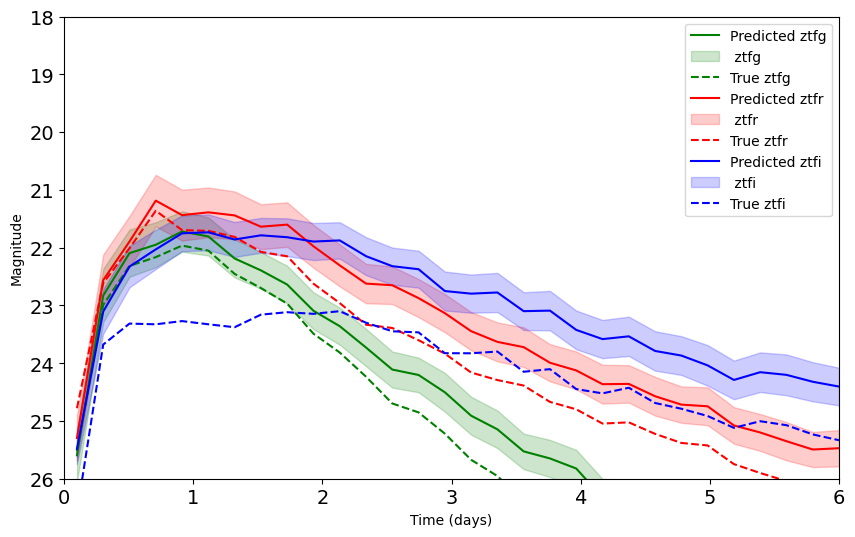

Worst performing light curves (Top 5): [ 705 1172 1740 1984  849]
MSE values of the worst performing light curves: [2.84226496 2.87924252 2.93110476 3.06998413 3.47748212]
Best performing light curves (Top 5): [ 963  365 2390 2158  897]
MSE values of the best performing light curves: [0.00439998 0.00453308 0.0060953  0.00621086 0.00656923]


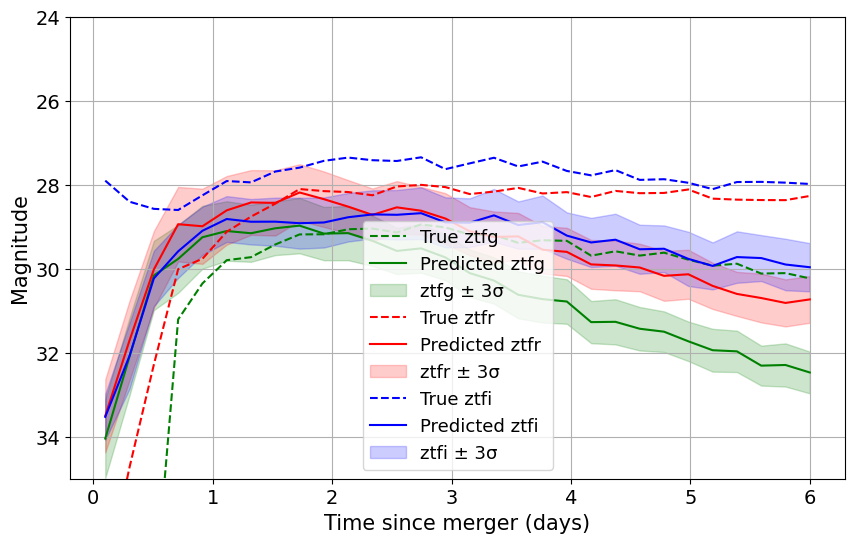

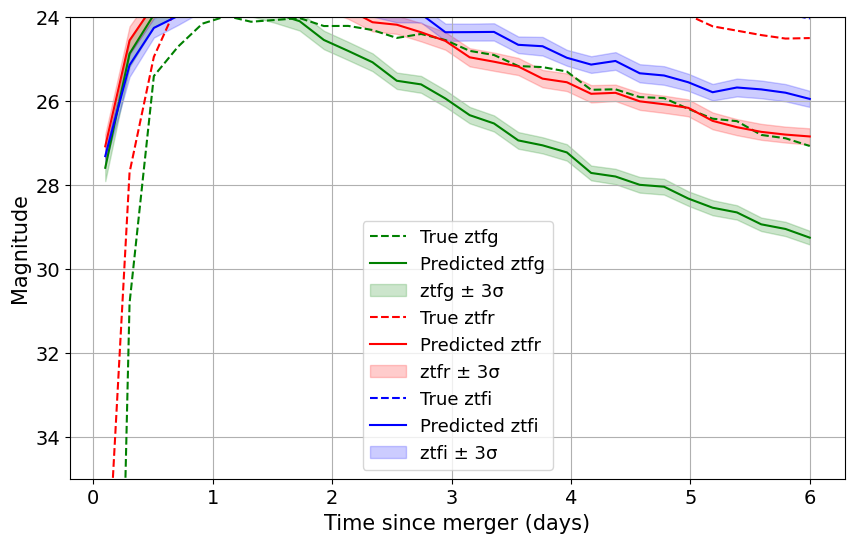

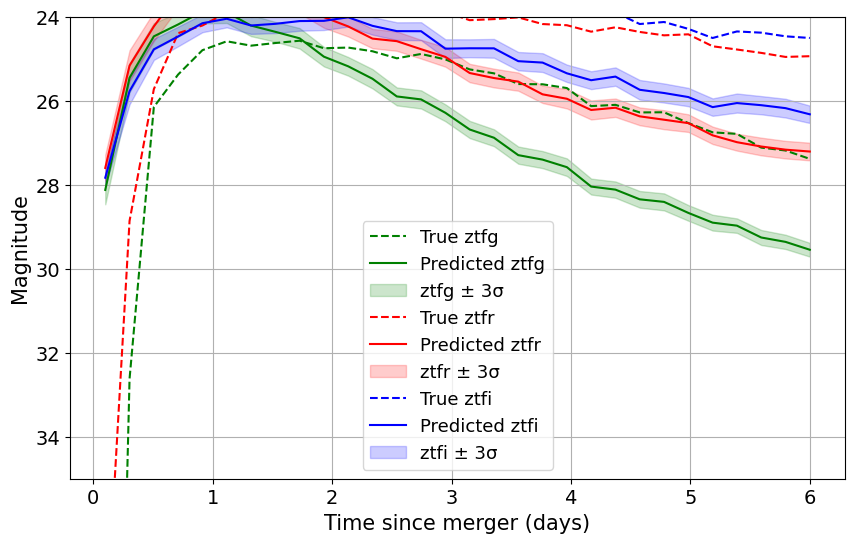

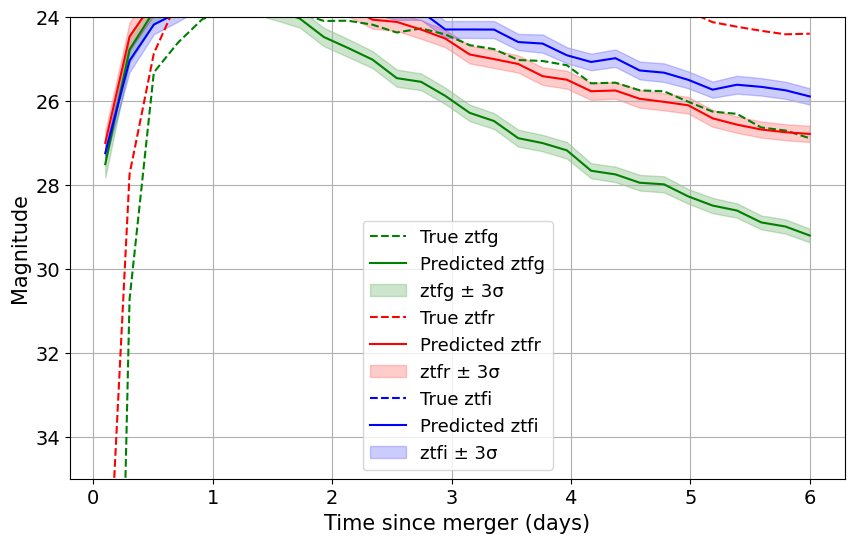

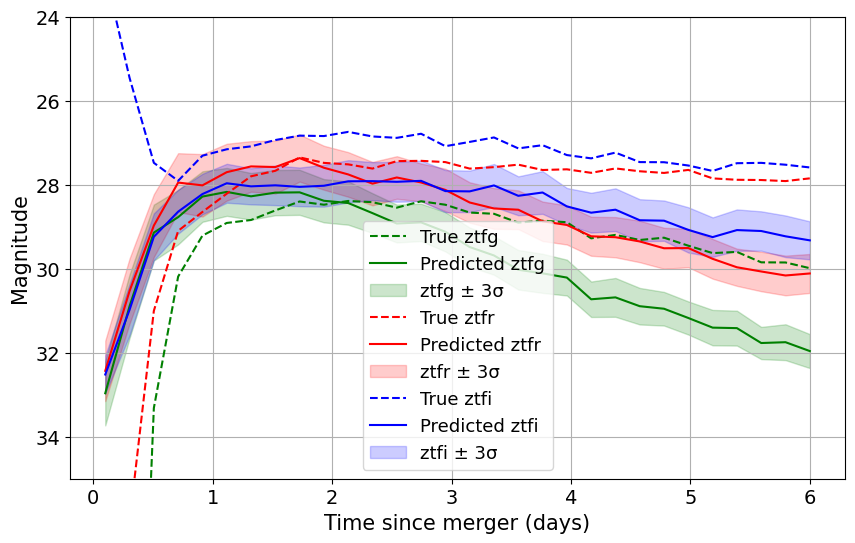

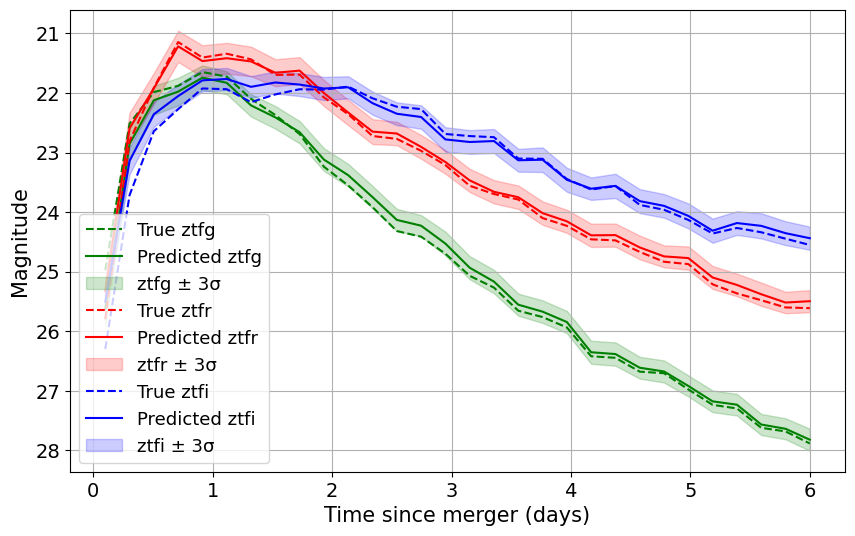

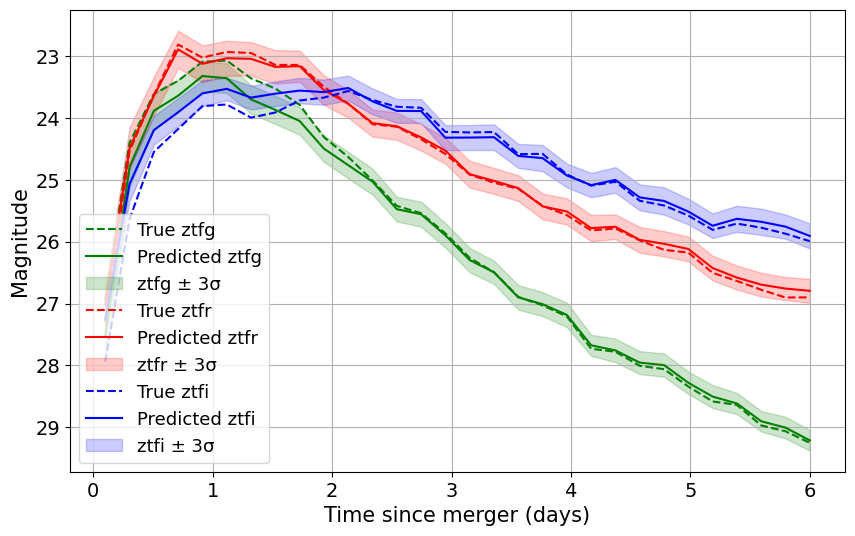

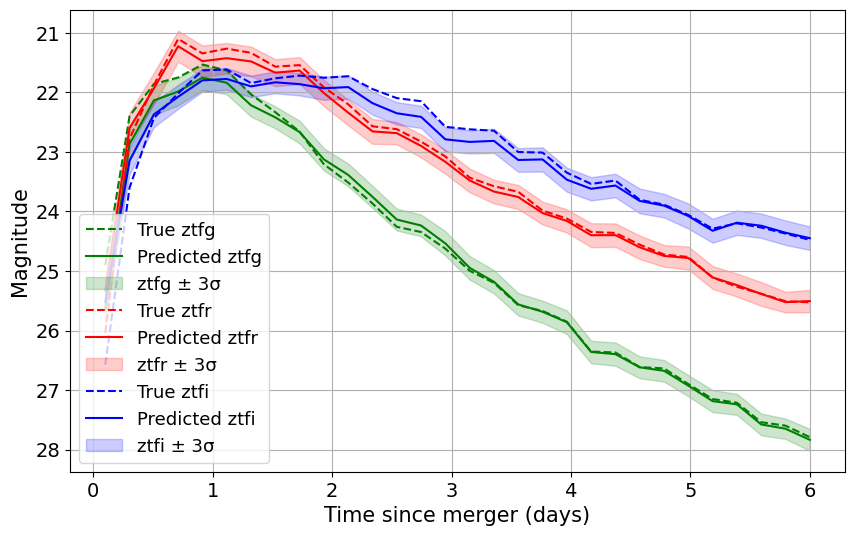

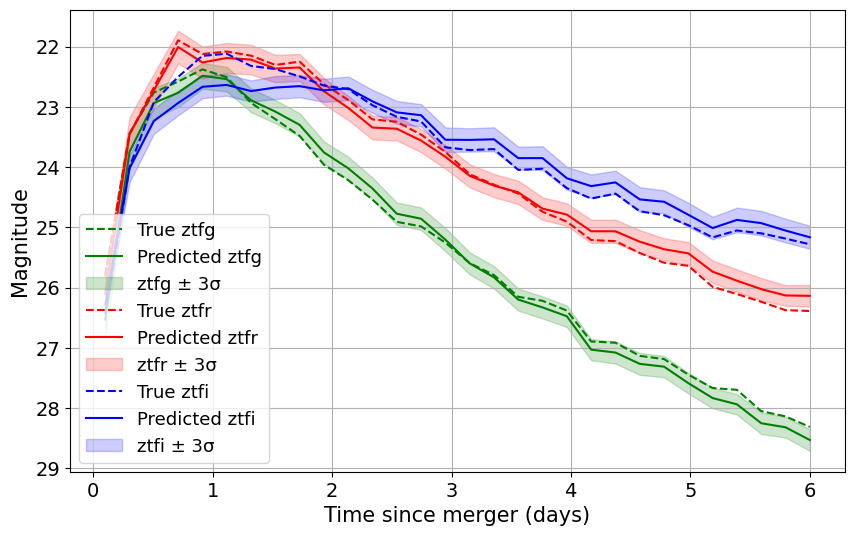

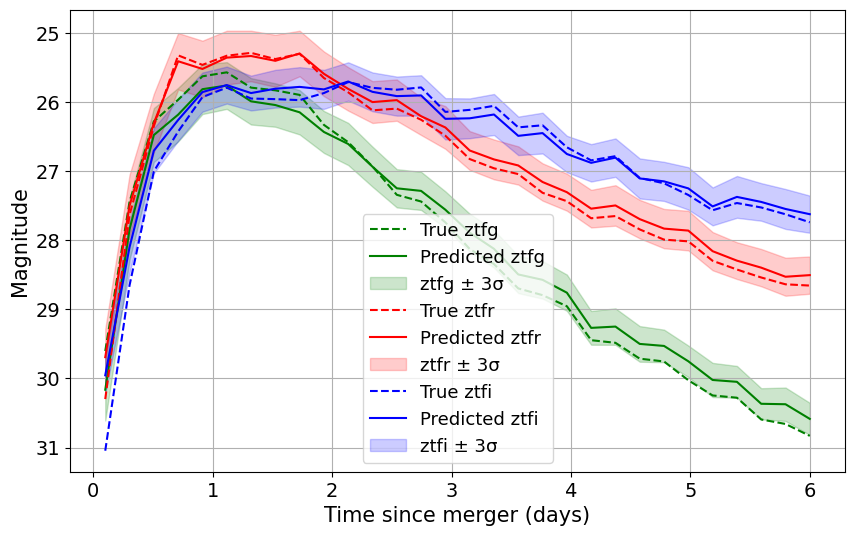

(2424, 30, 3)

--- Feature values for the Worst Performing Light Curves ---

Worst Light Curve 1 (Index 705) - MSE: 2.8423
area(90): 32211.6065
distance: 7513.3293
HasNS: 0.7979
HasRemnant: 0.0000
HasMassGap: 0.3771
PAstro: 0.8059

Worst Light Curve 2 (Index 1172) - MSE: 2.8792
area(90): 25241.9597
distance: 559.0905
HasNS: 1.0000
HasRemnant: 1.0000
HasMassGap: 0.2024
PAstro: 0.9971

Worst Light Curve 3 (Index 1740) - MSE: 2.9311
area(90): 1573.1691
distance: 762.9667
HasNS: 1.0000
HasRemnant: 0.8915
HasMassGap: 0.0578
PAstro: 0.9944

Worst Light Curve 4 (Index 1984) - MSE: 3.0700
area(90): 23094.6057
distance: 537.7052
HasNS: 1.0000
HasRemnant: 0.9631
HasMassGap: 0.8098
PAstro: 0.9757

Worst Light Curve 5 (Index 849) - MSE: 3.4775
area(90): 28337.5447
distance: 5036.6036
HasNS: 0.9050
HasRemnant: 0.0761
HasMassGap: 0.7802
PAstro: 0.4027

--- Feature values for the Best Performing Light Curves ---

Best Light Curve 1 (Index 963) - MSE: 0.0044
area(90): 849.0248
distance: 244.0223
HasNS

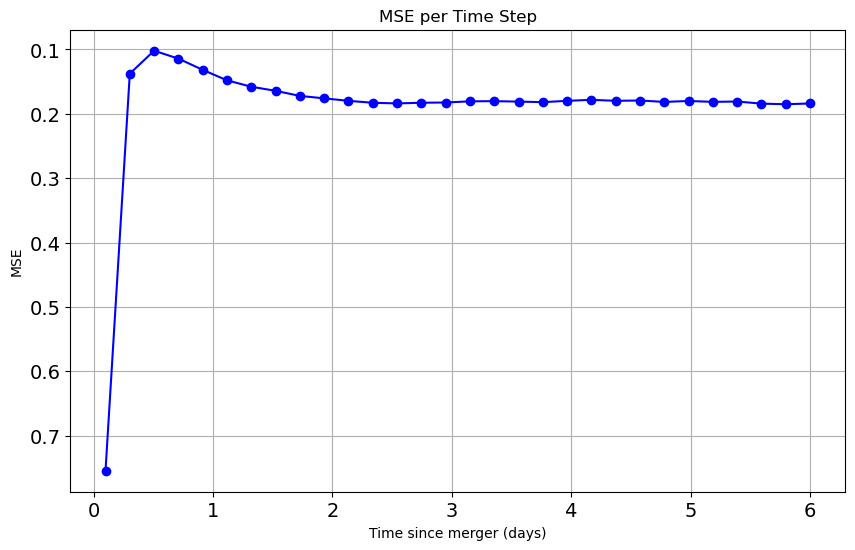

Number of light curves with MSE < 1: 2394
Number of light curves with MSE > 1: 30


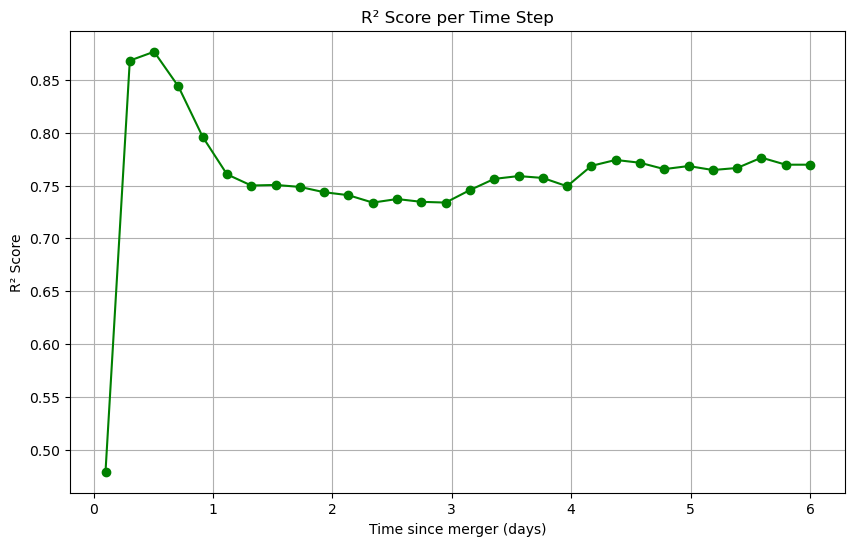

Average Time-Dependent R²: 0.7587
Average Time-Dependent MAPE: 3.7373
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8m

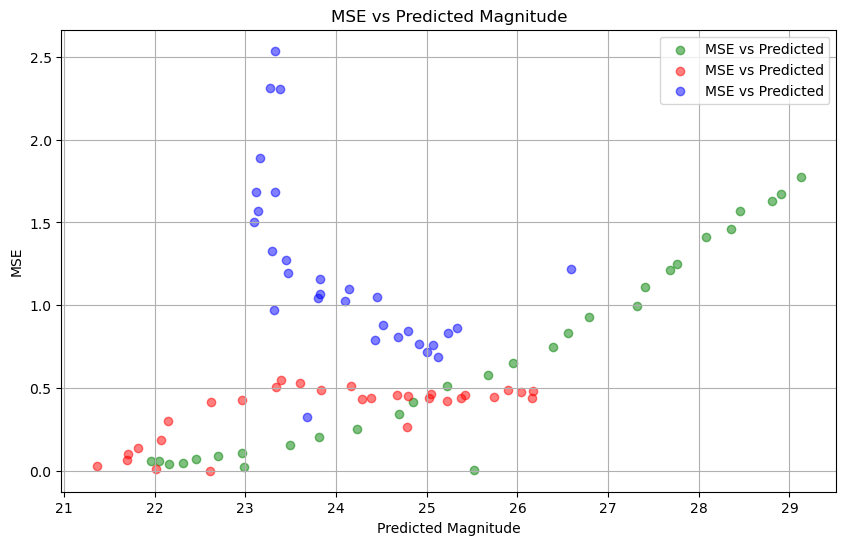

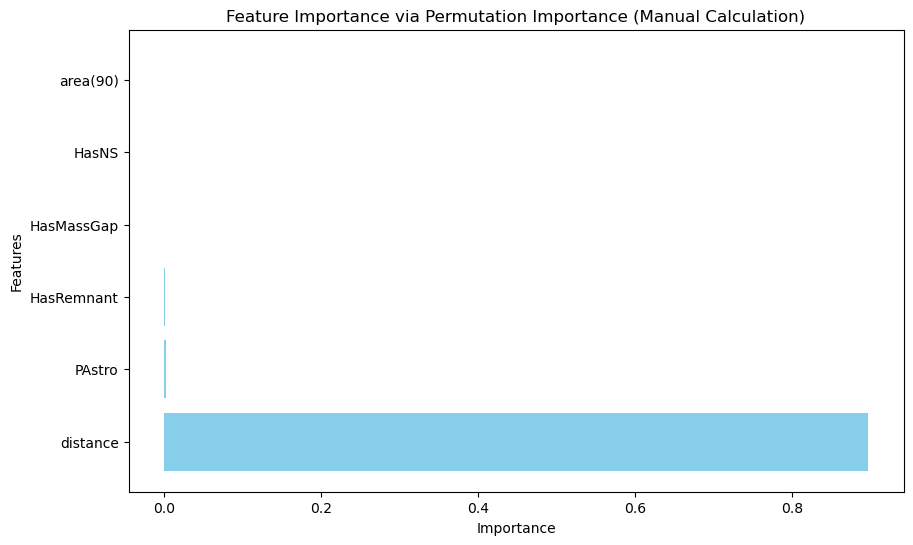

      Feature    Importance
1    distance  8.966318e-01
5      PAstro  2.341231e-03
3  HasRemnant  1.233825e-03
4  HasMassGap  1.790188e-04
2       HasNS  9.428124e-10
0    area(90) -1.479828e-04


In [11]:
# Plot the predicted light curves with uncertainty bands
plt.figure(figsize=(10, 6))

# Time points for plotting
time_points = np.tile(time_single, (X_test_reshaped.shape[0], 1))

# Invert the scaling for y_test to compare with predictions
y_test_inverted = target_scaler.inverse_transform(y_test.reshape(y_test.shape[0], -1)).reshape((y_test.shape[0], num_time_points, len(filter_order)))

# Select one example light curve to plot
example_idx = 0 # Index of the test example to plot
mean_curve = mean_preds_inverted[example_idx]
uncertainty_curve = uncertainty_reshaped[example_idx]

# Colors for each filter
colors = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'blue'}

# Plot the ZTFg, ZTFr, and ZTFi filters separately
filter_names = ['ztfg', 'ztfr', 'ztfi']
for i in range(len(filter_order)):
    plt.plot(time_single, mean_curve[:, i], label=f'Predicted {filter_names[i]}', color=colors[filter_names[i]])
    plt.fill_between(time_single, 
                     mean_curve[:, i] - 5 * uncertainty_curve[:, i], 
                     mean_curve[:, i] + 5 * uncertainty_curve[:, i], 
                     color=colors[filter_names[i]], alpha=0.2, label=f' {filter_names[i]}')

    # Plot the true values for comparison
    plt.plot(time_single, y_test_inverted[example_idx][:, i], '--', color=colors[filter_names[i]], label=f'True {filter_names[i]}')

plt.xlabel('Time (days)')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()  # Invert the y-axis for magnitude, since lower magnitude means brighter
#plt.title(f'Predicted Light Curve with Uncertainty (Example {example_idx})')
plt.legend()
plt.tick_params(axis='both', labelsize=14)
plt.ylim(26, 18)  
plt.xlim(0, 6) 
plt.show()

# Get the feature names from the 'features' DataFrame
feature_names = features.columns.tolist()  # This will include all remaining feature names
# Step 1: Calculate MSE for each light curve (normalized data)
mse_per_light_curve = np.zeros(y_test.shape[0])

for i in range(y_test.shape[0]):
    mse_per_light_curve[i] = mean_squared_error(y_test[i].reshape(-1), mean_preds[i].reshape(-1))

# Step 2: Identify the indices of the worst-performing light curves
worst_mse_indices = np.argsort(mse_per_light_curve)[-5:]  # Top 5 worst MSE
best_mse_indices = np.argsort(mse_per_light_curve)[:5]  # Top 5 best MSE

# Print the worst MSE light curves and their corresponding MSE values
print(f"Worst performing light curves (Top 5): {worst_mse_indices}")
print(f"MSE values of the worst performing light curves: {mse_per_light_curve[worst_mse_indices]}")

# Print the best MSE light curves and their corresponding MSE values
print(f"Best performing light curves (Top 5): {best_mse_indices}")
print(f"MSE values of the best performing light curves: {mse_per_light_curve[best_mse_indices]}")

# Step 3: Plot the true vs predicted light curves for the worst-performing samples
for idx in worst_mse_indices:
    plt.figure(figsize=(10, 6))
    for i, (filter_name, color) in enumerate(zip(filter_order, ['green', 'red', 'blue'])):
        true_curve = y_test_inverted[idx, :, i]
        predicted_curve = mean_preds_inverted[idx, :, i]
        uncertainty_curve = uncertainty_reshaped[idx, :, i]

        plt.plot(time_single, true_curve, label=f'True {filter_name}', linestyle='--', color=color)
        plt.plot(time_single, predicted_curve, label=f'Predicted {filter_name}', color=color)
        plt.fill_between(time_single,
                         predicted_curve - 3 * uncertainty_curve,
                         predicted_curve + 3 * uncertainty_curve,
                         color=color, alpha=0.2, label=f'{filter_name} ± 3σ')

    #plt.title(f"Worst Light Curve {idx} - MSE: {mse_per_light_curve[idx]:.4f}")
    plt.xlabel('Time since merger (days)', fontsize=15)
    plt.ylabel('Magnitude', fontsize=15)
    plt.tick_params(axis='both', labelsize=14)
    plt.legend(fontsize=13)
    plt.gca().invert_yaxis()
    plt.ylim(35, 24)  
    #plt.xlim(0, 6) 
    plt.grid(True)
    plt.show()


# Step 4: Plot the true vs predicted light curves for the best-performing samples
for idx in best_mse_indices:
    plt.figure(figsize=(10, 6))
    for i, (filter_name, color) in enumerate(zip(filter_order, ['green', 'red', 'blue'])):
        true_curve = y_test_inverted[idx, :, i]
        predicted_curve = mean_preds_inverted[idx, :, i]
        uncertainty_curve = uncertainty_reshaped[idx, :, i]

        plt.plot(time_single, true_curve, label=f'True {filter_name}', linestyle='--', color=color)
        plt.plot(time_single, predicted_curve, label=f'Predicted {filter_name}', color=color)
        plt.fill_between(time_single,
                         predicted_curve - 3 * uncertainty_curve,
                         predicted_curve + 3 * uncertainty_curve,
                         color=color, alpha=0.2, label=f'{filter_name} ± 3σ')

    #plt.title(f"Best Light Curve {idx} - MSE: {mse_per_light_curve[idx]:.4f}")
    plt.xlabel('Time since merger (days)', fontsize=15)
    plt.ylabel('Magnitude', fontsize=15)
    plt.legend(fontsize=13)
    plt.gca().invert_yaxis()
    plt.tick_params(axis='both', labelsize=14)
    plt.grid(True)
    plt.show()


# Ensure y_test and y_pred_test are reshaped properly for comparison
y_test_reshaped_for_comparison = y_test.reshape((y_test.shape[0], num_time_points, len(filter_order)))
print(y_test_reshaped_for_comparison.shape)
mean_preds_reshaped_for_comparison = mean_preds.reshape((mean_preds.shape[0], num_time_points, len(filter_order)))
# Step 5: Calculate and plot MSE per time step
# MSE is calculated across all filters and samples for each time step
mse_per_time_step = np.mean((y_test_reshaped_for_comparison - mean_preds_reshaped_for_comparison) ** 2, axis=(0, 2))

# Convert X_test back to unscaled form if needed
X_test_unscaled = feature_scaler.inverse_transform(X_test)

# Print feature values for worst predictions
print("\n--- Feature values for the Worst Performing Light Curves ---")
for i, idx in enumerate(worst_mse_indices):
    print(f"\nWorst Light Curve {i+1} (Index {idx}) - MSE: {mse_per_light_curve[idx]:.4f}")
    feature_values = X_test_unscaled[idx]
    for name, val in zip(feature_names, feature_values):
        print(f"{name}: {val:.4f}")

# Print feature values for best predictions
print("\n--- Feature values for the Best Performing Light Curves ---")
for i, idx in enumerate(best_mse_indices):
    print(f"\nBest Light Curve {i+1} (Index {idx}) - MSE: {mse_per_light_curve[idx]:.4f}")
    feature_values = X_test_unscaled[idx]
    for name, val in zip(feature_names, feature_values):
        print(f"{name}: {val:.4f}")


# Plot the MSE per time step
plt.figure(figsize=(10, 6))
plt.plot(time_single, mse_per_time_step, marker='o', linestyle='-', color='blue')
plt.xlabel('Time since merger (days)')
plt.ylabel('MSE')
plt.title('MSE per Time Step')
plt.tick_params(axis='both', labelsize=14)
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()
# Step 6: Count how many light curves have MSE < 0.1 and MSE > 0.1
mse_threshold = 1
num_mse_below_threshold = np.sum(mse_per_light_curve < mse_threshold)
num_mse_above_threshold = np.sum(mse_per_light_curve > mse_threshold)

# Print the counts
print(f"Number of light curves with MSE < {mse_threshold}: {num_mse_below_threshold}")
print(f"Number of light curves with MSE > {mse_threshold}: {num_mse_above_threshold}")

def calculate_time_dependent_metrics(y_true, y_pred, num_time_points, num_filters):
    r2_per_time_step = np.zeros(num_time_points)
    mape_per_time_step = np.zeros(num_time_points)
    
    # Iterate over each time step
    for t in range(num_time_points):
        y_true_flat = y_true[:, t, :].flatten()  # Flatten true values at time step t
        y_pred_flat = y_pred[:, t, :].flatten()  # Flatten predicted values at time step t
        
        # Calculate R² and MAPE for this time step
        r2_per_time_step[t] = r2_score(y_true_flat, y_pred_flat)
        mape_per_time_step[t] = np.mean(np.abs((y_true_flat - y_pred_flat) / y_true_flat)) * 100  # MAPE in percentage
    
    return r2_per_time_step, mape_per_time_step


# Calculate time-dependent R² and MAPE
r2_per_time_step, mape_per_time_step = calculate_time_dependent_metrics(y_test_inverted, mean_preds_inverted, num_time_points, len(filter_order))

# Plot Time-Dependent R²
plt.figure(figsize=(10, 6))
plt.plot(time_single, r2_per_time_step, marker='o', color='green', label='R²')
plt.xlabel('Time since merger (days)')
plt.ylabel('R² Score')
plt.title('R² Score per Time Step')
plt.grid(True)
plt.show()

# Average Time-Dependent Metrics
average_r2 = np.mean(r2_per_time_step)
average_mape = np.mean(mape_per_time_step)
print(f'Average Time-Dependent R²: {average_r2:.4f}')
print(f'Average Time-Dependent MAPE: {average_mape:.4f}')


from sklearn.utils import shuffle

def calculate_mse(model, X, y_true):
    """
    Helper function to calculate MSE given the model and dataset.
    """
    y_pred = model.predict(X)
    y_pred = y_pred.reshape(y_true.shape)  # Reshape to match y_true
    mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
    return mse

def permutation_importance_keras(model, X_test, y_test, n_repeats=10):
    """
    Manually calculate permutation importance for a Keras model.
    """
    baseline_mse = calculate_mse(model, X_test, y_test)
    importances = np.zeros(X_test.shape[2])  # Initialize importances for each feature
    
    for i in range(X_test.shape[2]):  # Loop through each feature
        mse_repeats = np.zeros(n_repeats)
        
        for n in range(n_repeats):
            # Create a copy of X_test to shuffle one feature
            X_test_permuted = np.copy(X_test)
            
            # Shuffle the i-th feature in X_test
            X_test_permuted[:, :, i] = shuffle(X_test_permuted[:, :, i])
            
            # Calculate MSE with the shuffled feature
            mse_repeats[n] = calculate_mse(model, X_test_permuted, y_test)
        
        # Calculate the mean increase in MSE due to shuffling this feature
        importances[i] = np.mean(mse_repeats) - baseline_mse
    
    return importances

# Get the feature names from the 'features' DataFrame
feature_names = features.columns.tolist()  # This will include all remaining feature names

# Calculate permutation importance for the features
importances = permutation_importance_keras(model, X_test_reshaped, y_test_reshaped)

# Create a DataFrame to display results with feature names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# Step: Calculate MSE per point (between y_test and y_pred_test)
mse_per_pointg = (y_test_inverted[0, :, 0].flatten() - mean_preds_inverted[0, :, 0].flatten()) ** 2
mse_per_pointr = (y_test_inverted[0, :, 1].flatten() - mean_preds_inverted[0, :, 1].flatten()) ** 2
mse_per_pointi = (y_test_inverted[0, :, 2].flatten() - mean_preds_inverted[0, :, 2].flatten()) ** 2
print(mse_per_pointg.shape)
test_mseg = mean_squared_error(y_test_inverted[0, :, 0].flatten(), mean_preds_inverted[0, :, 0].flatten())
test_mser = mean_squared_error(y_test_inverted[0, :, 1].flatten(), mean_preds_inverted[0, :, 1].flatten())
test_msei = mean_squared_error(y_test_inverted[0, :, 2].flatten(), mean_preds_inverted[0, :, 2].flatten())
print('ztfg', test_mseg)
print('ztfr', test_mser)
print('ztfi', test_msei)
# Step: Plot MSE vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_inverted[0, :, 0].flatten(), mse_per_pointg , alpha=0.5, color='green', label='MSE vs Predicted')
plt.scatter(y_test_inverted[0, :, 1].flatten(), mse_per_pointr , alpha=0.5, color='red', label='MSE vs Predicted')
plt.scatter(y_test_inverted[0, :, 2].flatten(), mse_per_pointi , alpha=0.5, color='blue', label='MSE vs Predicted')
plt.xlabel('Predicted Magnitude')
plt.ylabel('MSE')
plt.title('MSE vs Predicted Magnitude')
plt.grid(True)

plt.legend()
plt.show()


# Create a DataFrame to display results with feature names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance via Permutation Importance (Manual Calculation)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Display the importance DataFrame
print(importance_df)

(2424, 30, 3)
(2424, 30, 3)


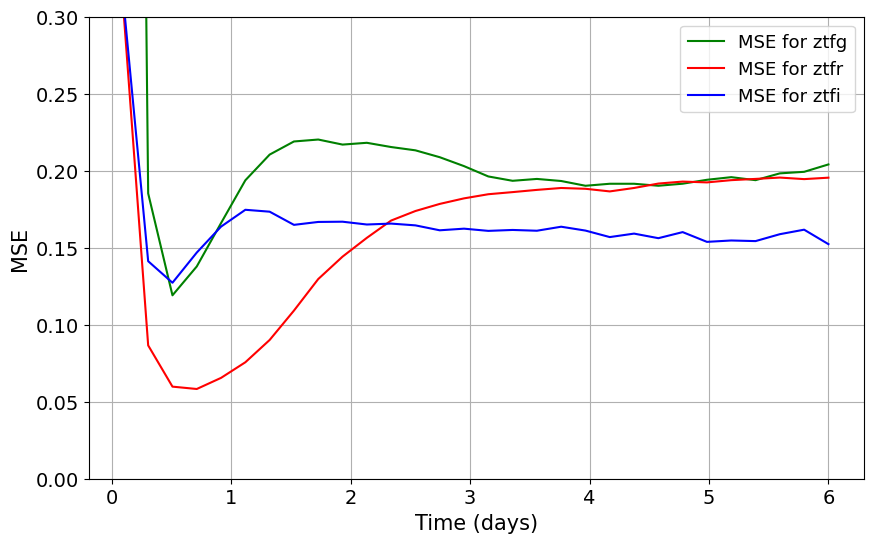

{'ztfg': 0.24335744226503003,
 'ztfr': 0.16133077247181166,
 'ztfi': 0.1642643236644725}

In [12]:
# Loop over each filter and compute MSE at each time step
mse_vs_time = {}
filter_names = ['ztfg', 'ztfr', 'ztfi']
colors = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'blue'}
y_test_reshaped = y_test.reshape(y_test.shape[0], num_time_points, 3) 
print(y_test_reshaped.shape)
mean_preds_reshaped = mean_preds.reshape(mean_preds.shape[0], num_time_points, 3) 
print(mean_preds_reshaped.shape)
for i, filter_name in enumerate(filter_names):
    # Calculate MSE at each time step (averaged across all light curves)
    mse_per_time_step = np.mean((y_test_reshaped[:,:,i] - mean_preds_reshaped[:,:,i]) ** 2, axis=0)  
    
    mse_vs_time[filter_name] = mse_per_time_step

plt.figure(figsize=(10, 6))

for filter_name in filter_names:
    plt.plot(time_single, mse_vs_time[filter_name], label=f'MSE for {filter_name}', color=colors[filter_name])

# Add labels and title
plt.xlabel('Time (days)', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
#plt.title('MSE vs Time Step for Each Filter')
plt.legend(fontsize=13)
plt.grid(True)
#plt.gca().invert_yaxis() 
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim(0, 0.3) 
plt.tick_params(axis='both', labelsize=14)
plt.show()
average_mse_per_filter = {filter_name: np.mean(mse_vs_time[filter_name]) for filter_name in filter_names}

average_mse_per_filter